# 📓This notebook cointains:
1. Loading the relevant dataset,
2. Data loading
3. Training loops for each architecture
4. Evaluations

It can be run with different hyperparams as you wish.

# 🌍Setup inviroment and installing dependencies

In [ ]:
# Mounting the drive if using google colab:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
# installing dependencies
if RunningInCOLAB:
  !pip install torch torchvision torchaudio
  !pip install sentence-transformers
  !pip install scikit-learn
  !pip install pandas matplotlib pillow
else:
  %pip install torch torchvision torchaudio
  %pip install sentence-transformers
  %pip install scikit-learn
  %pip install pandas matplotlib pillow


  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

# ⏬Imports

In [15]:
import pickle
import io
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.utils import resample
from sentence_transformers import SentenceTransformer
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from google.colab import drive
import gc
import os


# 🎶Loading Datasets:
1. loaded_df = our main dataset, consists of spoctrograms (PIL format) and text features for songs. size: ~3K samples.
2. spotify_loaded_df = external large dataset without spectrograms, only text feature. size: ~550K samples

In [16]:
# Load dataset #
with open("/content/drive/MyDrive/projecton/processed_data_regression.pkl", "rb") as f:
    loaded_df = pickle.load(f)
loaded_df = pd.DataFrame(loaded_df)

# Convert all images from bytes to PIL.Image
loaded_df['spectrogram'] = loaded_df['spectrogram'].apply(lambda x: Image.open(io.BytesIO(x)) if isinstance(x, bytes) else x)

with open("/content/drive/MyDrive/projecton/spotify_data.pkl", "rb") as f:
    spotify_loaded_df = pickle.load(f)
spotify_loaded_df = pd.DataFrame(spotify_loaded_df)
spotify_loaded_df.rename(columns = {'artists' : 'artist'}, inplace = True)


# ⚡Seperating the datasets:
filtered_spotify_df is a large dataset includes only samples doesn't appear in loaded_df. size: ~547K

In [18]:
# Ensure the key columns are the same
key_columns = ['name', 'artist', 'release_date']

# Perform the filtering
filtered_spotify_df = spotify_loaded_df.merge(loaded_df[key_columns], on=key_columns, how='left', indicator=True)
filtered_spotify_df = filtered_spotify_df[filtered_spotify_df['_merge'] == 'left_only'].drop(columns=['_merge'])


# 🔍Datasets Overview

In [38]:
loaded_df

,name,artist,release_date,spectrogram,popularity
0,O Dio Mio,Annette Funicello,1960,<PIL.PngImagePlugin.PngImageFile image mode=L ...,13.0
1,Beyond the Sea,Bobby Darin,2004,<PIL.PngImagePlugin.PngImageFile image mode=L ...,60.0
2,Devil Or Angel,Bobby Vee,1960,<PIL.PngImagePlugin.PngImageFile image mode=L ...,36.0
3,Itsy Bitsy Teenie Weenie Yellow Polka Dot Bikini,Brian Hyland,1961,<PIL.PngImagePlugin.PngImageFile image mode=L ...,56.0
4,Among My Souvenirs,Connie Francis,1996,<PIL.PngImagePlugin.PngImageFile image mode=L ...,39.0
...,...,...,...,...,...
3190,Dance Monkey,Tones And I,2020,<PIL.PngImagePlugin.PngImageFile image mode=L ...,5.0
3191,HIGHEST IN THE ROOM,Travis Scott,2019,<PIL.PngImagePlugin.PngImageFile image mode=L ...,87.0
3192,Falling,Trevor Daniel,2020,<PIL.PngImagePlugin.PngImageFile image mode=L ...,78.0
3193,Suicidal,YNW Melly,2019,<PIL.PngImagePlugin.PngImageFile image mode=L ...,80.0


In [39]:
filtered_spotify_df

,name,popularity,artist,release_date
0,Carve,6,Uli,1922
1,Capítulo 2.16 - Banquero Anarquista,0,Fernando Pessoa,1922
2,Vivo para Quererte - Remasterizado,0,Ignacio Corsini,1922
3,El Prisionero - Remasterizado,0,Ignacio Corsini,1922
4,Lady of the Evening,0,Dick Haymes,1922
...,...,...,...,...
526604,云与海,50,阿YueYue,2020
526605,blind,72,ROLE MODEL,2020
526606,What They'll Say About Us,70,FINNEAS,2020
526607,A Day At A Time,58,Gentle Bones,2021


# 🏋Tokenizing Dataset:
Using Huggin Face sentence-transformers model.
It maps sentences & paragraphs to a 384 dimensional dense vector space.

In [19]:
model_LM = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [20]:
# Tokenzing the spotify dataset (on filtered_spotify_df)
transformers_text_features = filtered_spotify_df[['name', 'artist', 'release_date']].copy()
transformers_text_features['year'] = transformers_text_features['release_date'].str.split('/').str[-1].astype(np.float32)
transormers_labels = filtered_spotify_df['popularity'].values

# Encode 'name' and 'artists' as numerical vectors
transformers_name_embeddings = model_LM.encode(transformers_text_features['name'].tolist(), convert_to_numpy=True)
transformers_artist_embeddings = model_LM.encode(transformers_text_features['artist'].tolist(), convert_to_numpy=True)

# Ensure that embeddings are in float32
transformers_name_embeddings = np.array(transformers_name_embeddings, dtype=np.float32)
transformers_artist_embeddings = np.array(transformers_artist_embeddings, dtype=np.float32)


In [21]:
# Tokenzing the combined dataset (on loaded_df)
combined_text_features = loaded_df[['name', 'artist', 'release_date']].copy()
combined_text_features['year'] = combined_text_features['release_date'].str.split('/').str[-1].astype(np.float32)
combined_labels = loaded_df['popularity'].values

# Encode 'name' and 'artists' as numerical vectors
combined_name_embeddings = model_LM.encode(combined_text_features['name'].tolist(), convert_to_numpy=True)
combined_artist_embeddings = model_LM.encode(combined_text_features['artist'].tolist(), convert_to_numpy=True)

# Ensure that embeddings are in float32
combined_name_embeddings = np.array(combined_name_embeddings, dtype=np.float32)
combined_artist_embeddings = np.array(combined_artist_embeddings, dtype=np.float32)

# 📭Hyper-parameters
You can modify as you wish. 
# 4 main architectures:
 1. Transformer- a neural network which is learning based on the large seperated dataset
 2. CNN - a convolution neural network that is learning based on small dataset (spectrograms)
 3. "Naive" combined model - concat 1.+2. from layer before output into a neural network. transformer and CNN are not pre-trained
 4. "Smart" combined model - the same as Naive but transformer and CNN are pretrained, the model use them for inference in the internal network.

In [22]:
# Batch sizes
transformer_batch_size = 16
Comb_batch_size = 8
CNN_batch_size = 4

# Learning Rates
Transformer_LR = 0.001
CNN_LR = 0.02
Naive_LR = 0.01
Smart_LR = 0.01

# Epochs
Transformer_epochs = 1000
CNN_epochs = 20
Naive_epochs = 15
Smart_epochs = 15

# Loss
criterion = nn.MSELoss()

# Accuracy parameter
tolerance = 15

# 🖥️ Creating DataLoaders models
prepare datasets and DataLoaders for training models using spectrograms and text features, splitting data into training, validation, and test sets.

Data Augmentation for spectrograms: adding noise and random patching.

In [35]:
# Creating DataLoaders for all models #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#---------------------------------------------------------------------------------------------#
# Data process for Combined models ("Naive") - text features and spectograms (~3K)
class MusicDataset(Dataset):
    def __init__(self, spectrograms, text_features, labels):
        self.spectrograms = torch.tensor(spectrograms, dtype=torch.float32).unsqueeze(1).to(device)  # Add channel dim
        self.text_features = torch.tensor(text_features, dtype=torch.float32).to(device)  # Convert DataFrame to numpy first
        self.labels = torch.tensor(labels, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.text_features[idx], self.labels[idx]

# Combine features
combined_X_text_features = np.hstack((combined_name_embeddings, combined_artist_embeddings, combined_text_features[['year']].values))
X_spectrograms = np.array(loaded_df['spectrogram'].tolist(), dtype=np.float32)

# Combined model dataset
train_spectrograms, temp_spectrograms, train_text_features, temp_text_features, train_labels, temp_labels = train_test_split(
    X_spectrograms, combined_X_text_features, combined_labels, test_size=0.3, random_state=42
)
val_spectrograms, test_spectrograms, val_text_features, test_text_features, val_labels, test_labels = train_test_split(
    temp_spectrograms, temp_text_features, temp_labels, test_size=0.5, random_state=42
)

# Create Datasets and Loaders
train_dataset_comb = MusicDataset(train_spectrograms, train_text_features, train_labels)
val_dataset_comb = MusicDataset(val_spectrograms, val_text_features, val_labels)
test_dataset_comb = MusicDataset(test_spectrograms, test_text_features, test_labels)

train_loader_comb = DataLoader(train_dataset_comb, batch_size=Comb_batch_size ,  shuffle=True)
val_loader_comb = DataLoader(val_dataset_comb, batch_size=Comb_batch_size, shuffle=False)
test_loader_comb = DataLoader(test_dataset_comb, batch_size=Comb_batch_size, shuffle=False)
#---------------------------------------------------------------------------------------------#
# Data process for Combined models ("Smart") - text features and spectograms
# Combine features
combined_labels2 = combined_labels.copy()
combined_X_text_features2 = np.hstack((combined_name_embeddings, combined_artist_embeddings, combined_text_features[['year']].values))
X_spectrograms2 = np.array(loaded_df['spectrogram'].tolist(), dtype=np.float32)

# Combined model dataset
train_spectrograms2, temp_spectrograms2, train_text_features2, temp_text_features2, train_labels2, temp_labels2 = train_test_split(
    X_spectrograms2, combined_X_text_features2, combined_labels2, test_size=0.3, random_state=42
)
val_spectrograms2, test_spectrograms2, val_text_features2, test_text_features2, val_labels2, test_labels2 = train_test_split(
    temp_spectrograms2, temp_text_features2, temp_labels2, test_size=0.5, random_state=42
)

# Create Datasets and Loaders
train_dataset_comb2 = MusicDataset(train_spectrograms2, train_text_features2, train_labels2)
val_dataset_comb2 = MusicDataset(val_spectrograms2, val_text_features2, val_labels2)
test_dataset_comb2= MusicDataset(test_spectrograms2, test_text_features2, test_labels2)

train_loader_comb2 = DataLoader(train_dataset_comb2, batch_size=Comb_batch_size ,  shuffle=True)
val_loader_comb2 = DataLoader(val_dataset_comb2, batch_size=Comb_batch_size, shuffle=False)
test_loader_comb2= DataLoader(test_dataset_comb2, batch_size=Comb_batch_size, shuffle=False)
#---------------------------------------------------------------------------------------------#
# Data process for Transformer-spotify data, without spectrograms

# Stack all features together (name embeddings, artist embeddings, and year)
transformer_x_text_features = np.hstack((transformers_name_embeddings, transformers_artist_embeddings, transformers_text_features[['year']].values))

# Split the dataset into train, validation, and test sets
transformer_train, X_temp, transformer_label_train, y_temp = train_test_split(transformer_x_text_features, transormers_labels, test_size=0.8, random_state=42)
transformer_val, transformer_test, transformer_label_val, transformer_label_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors and move to device
transformer_train_tensor = torch.tensor(transformer_train, dtype=torch.float32).to(device)
transformer_val_tensor = torch.tensor(transformer_val, dtype=torch.float32).to(device)
transformer_test_tensor = torch.tensor(transformer_test, dtype=torch.float32).to(device)

transformer_label_train_tensor = torch.tensor(transformer_label_train, dtype=torch.float32).unsqueeze(1).to(device)
transformer_label_val_tensor = torch.tensor(transformer_label_val, dtype=torch.float32).unsqueeze(1).to(device)
transformer_label_test_tensor = torch.tensor(transformer_label_test, dtype=torch.float32).unsqueeze(1).to(device)

# DataLoaders
transformer_train_loader = DataLoader(torch.utils.data.TensorDataset(transformer_train_tensor, transformer_label_train_tensor), batch_size=transformer_batch_size, shuffle=True)
transformer_val_loader = DataLoader(torch.utils.data.TensorDataset(transformer_val_tensor, transformer_label_val_tensor), batch_size=transformer_batch_size, shuffle=False)
transformer_test_loader = DataLoader(torch.utils.data.TensorDataset(transformer_test_tensor, transformer_label_test_tensor), batch_size=transformer_batch_size, shuffle=False)

#---------------------------------------------------------------------------------------------#
# Data process for CNN- spectrograms data without text features
# Augmentations for spectograms
class AddWhiteNoise(object):
    def __init__(self, noise_factor=0.02):
        self.noise_factor = noise_factor

    def __call__(self, image):
        noise = torch.randn_like(image) * self.noise_factor
        image = image + noise
        image = torch.clamp(image, 0.0, 1.0)  # Keep image in range [0, 1]
        return image

class RandomPatch(object):
    def __init__(self, Patch_size=(32, 32),p = 0.3):
        self.Patch_size = Patch_size
        self.p = p

    def __call__(self, image):
        if random.random() < self.p:
            # Randomly Patch the image to a smaller size
            height, width = image.shape[1], image.shape[2]
            Patch_height, Patch_width = self.Patch_size

            top = np.random.randint(0, height - Patch_height)
            left = np.random.randint(0, width - Patch_width)

            image[:, top:top + Patch_height, left:left + Patch_width] = 0
        return image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor
    AddWhiteNoise(noise_factor=0.02),  # Add white noise with a small factor
    RandomPatch(Patch_size=(128, 32),p = 0.3),  # Random Patching
    RandomPatch(Patch_size=(128, 32),p = 0.3),  # Random Patching
    RandomPatch(Patch_size=(128, 32),p = 0.3),  # Random Patching
    RandomPatch(Patch_size=(128, 32),p = 0.3),  # Random Patching
    RandomPatch(Patch_size=(128, 32),p = 0.3),  # Random Patching
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor
])

class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels, transform=None):
        self.spectrograms = spectrograms  # Expecting PIL images now
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)  # regression labels
        self.transform = transform

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        image = Image.fromarray(self.spectrograms[idx])  # Directly use the PIL image
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Create DataLoaders
train_dataset_spec = SpectrogramDataset(train_spectrograms, train_labels, transform=transform)
val_dataset_spec = SpectrogramDataset(val_spectrograms, val_labels, transform=transform)
test_dataset_spec = SpectrogramDataset(test_spectrograms, test_labels, transform=transform_test)

train_loader_spec = DataLoader(train_dataset_spec, batch_size=CNN_batch_size, shuffle=True)
val_loader_spec = DataLoader(val_dataset_spec, batch_size=CNN_batch_size, shuffle=False)
test_loader_spec = DataLoader(test_dataset_spec, batch_size=CNN_batch_size, shuffle=False)


# 🎮 Model defenitions and architectures

In [24]:
# Transformer
class TransformerPredictor(nn.Module):
    def __init__(self, input_size):
        super(TransformerPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x, extract_features=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        if extract_features:
            return x # returning 64 output width
        x = self.fc3(x)
        return x # returning 1 output width

# CNN
class SpectrogramCNN(nn.Module):
    def __init__(self, input_height=256, input_width=1024, dropout_p=0.5):
        super(SpectrogramCNN, self).__init__()

        self.input_height = input_height
        self.input_width = input_width

        # First convolutional block (3x7)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 7), padding=(1, 3))
        self.pointwise1 = nn.Conv2d(16, 16, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Second convolutional block (5x7)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5, 7), padding=(2, 3), groups=16)
        self.pointwise2 = nn.Conv2d(32, 32, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional block (1x5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 5), padding=(0, 2), groups=32)
        self.pointwise3 = nn.Conv2d(64, 64, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Dropout for convolutional layers
        self.dropout_conv = nn.Dropout(p=dropout_p)

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 1)

        # Batch Normalization for FC layers
        self.bn_fc1 = nn.BatchNorm1d(64)

        # Dropout for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_p)

    def forward(self, x, extract_features=False):
        x = F.relu(self.bn1(self.pointwise1(self.conv1(x))))
        x = self.dropout_conv(x)
        x = F.max_pool2d(x, (2, 2))

        x = F.relu(self.bn2(self.pointwise2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = F.max_pool2d(x, (2, 2))

        x = F.relu(self.bn3(self.pointwise3(self.conv3(x))))
        x = self.dropout_conv(x)
        x = F.max_pool2d(x, (2, 2))

        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc(x)
        if extract_features:
            return x # returning 64 output width
        x = self.fc2(x)
        return x # returning 1 output width

# Combined model
class CombinedModel(nn.Module):
    def __init__(self, cnn, transformer):
        super(CombinedModel, self).__init__()
        self.cnn = cnn
        self.transformer = transformer
        self.fc_combined = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, cnn_input, transformer_input, naive = False):
        cnn_input = cnn_input.to(device)
        transformer_input = transformer_input.to(device)
        if naive:
            cnn_features = self.cnn(cnn_input, extract_features=True)  # (Batch, 64)
            transformer_features = self.transformer(transformer_input, extract_features=True)  # (Batch, 64)
        else:
            with torch.no_grad():  # Freeze CNN and Transformer
                cnn_features = self.cnn(cnn_input, extract_features=True)  # (Batch, 64)
                transformer_features = self.transformer(transformer_input, extract_features=True)  # (Batch, 64)

        # Concatenate features
        combined_features = torch.cat((cnn_features, transformer_features), dim=1)  # (Batch, 128)

        # Pass through FC NN
        output = self.fc_combined(combined_features)
        return output



# 🔥 Initialize models and training models

In [26]:
transformerpredictor_model = TransformerPredictor(transformer_train.shape[1]).to(device)
CNN_model = SpectrogramCNN().to(device)
transformerpredictor_model_no_pretrain = TransformerPredictor(train_text_features.shape[1]).to(device)
CNN_model_no_pretrain = SpectrogramCNN().to(device)
naivepredictor_model = CombinedModel(CNN_model_no_pretrain,transformerpredictor_model_no_pretrain).to(device)

In [ ]:
# Train Transformer
transformer_optimizer = optim.Adam(transformerpredictor_model.parameters(), lr=Transformer_LR)

# Train the model
transformer_train_losses = []
transformer_val_losses = []

for epoch in range(Transformer_epochs):
    transformerpredictor_model.train()

    running_train_loss = 0.0
    for batch_idx, (X_batch, y_batch) in enumerate(transformer_train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = transformerpredictor_model(X_batch)
        loss = criterion(outputs, y_batch)

        transformer_optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(transformer_train_loader)
    transformer_train_losses.append(avg_train_loss)

    # Validation
    transformerpredictor_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in transformer_val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = transformerpredictor_model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(transformer_val_loader)
    transformer_val_losses.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{Transformer_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

In [ ]:
# Test Tranformer #
Plot training and validation losses
plt.plot(range(1, Transformer_epochs + 1), transformer_train_losses, label='Train Loss')
plt.plot(range(1, Transformer_epochs + 1), transformer_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate accuracy on the test set
transformerpredictor_model.eval()

# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient calculation for inference
    for text_features, labels in transformer_test_loader:  # Using the DataLoader
        text_features, labels = text_features.to(device), labels.to(device)

        # Forward pass: get raw logits from the model
        y_pred_logits = transformerpredictor_model(text_features)  # Modify based on your model's forward function

        # Calculate accuracy with tolerance
        y_pred = y_pred_logits.squeeze()  # Ensure shape matches (N,)
        labels = labels.squeeze()

        correct_predictions += torch.sum(torch.abs(y_pred - labels) <= tolerance).item()
        total_predictions += labels.numel()

# Calculate accuracy
accuracy = (correct_predictions / total_predictions) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

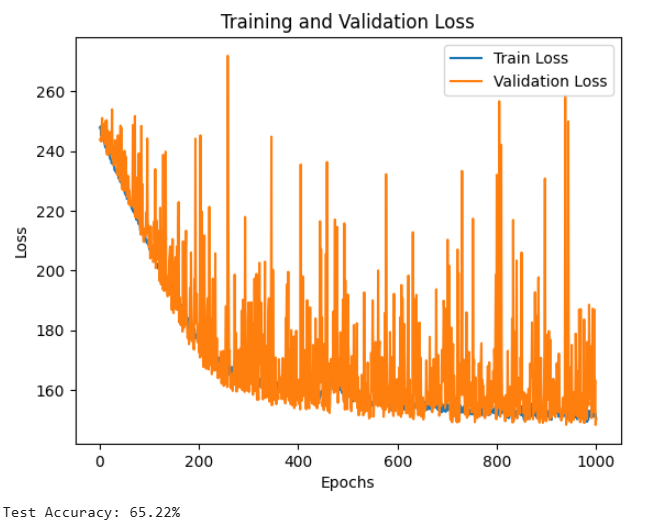

## ❕Note: The previous model gets a good accuracy, but is trained on a dataset of 500K+ samples!
##         In our project for analysis spectrograms, we only able to learn from ~3K images.

In [ ]:
# Save Transformer #
torch.save(transformerpredictor_model.state_dict(), 'transformer_model_pre_train.pth')

In [28]:
# Train CNN
optimizer = optim.Adam(CNN_model.parameters(), lr=CNN_LR)

# Training Loop
train_losses_spec, val_losses_spec = [], []

for epoch in range(CNN_epochs):
    CNN_model.train()
    epoch_loss = 0

    for i, (X_batch, y_batch) in enumerate(train_loader_spec):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = CNN_model(X_batch)
        loss = criterion(outputs, y_batch.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader_spec)
    train_losses_spec.append(epoch_loss / len(train_loader_spec))

# Validation
    CNN_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_spec:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = CNN_model(X_batch)
            val_loss = criterion(val_outputs, y_batch.float().unsqueeze(1))
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader_spec)
    val_losses_spec.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{CNN_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch [1/20], Train Loss: 471.0319, Validation Loss: 341.2896
Epoch [2/20], Train Loss: 346.8940, Validation Loss: 308.2508
Epoch [3/20], Train Loss: 335.6038, Validation Loss: 323.3158
Epoch [4/20], Train Loss: 339.6750, Validation Loss: 307.2939
Epoch [5/20], Train Loss: 333.0945, Validation Loss: 310.0726
Epoch [6/20], Train Loss: 328.2878, Validation Loss: 321.3550
Epoch [7/20], Train Loss: 318.7961, Validation Loss: 313.7621
Epoch [8/20], Train Loss: 319.5074, Validation Loss: 315.1888
Epoch [9/20], Train Loss: 325.9642, Validation Loss: 308.1873
Epoch [10/20], Train Loss: 317.8425, Validation Loss: 309.4739
Epoch [11/20], Train Loss: 323.1795, Validation Loss: 335.1117
Epoch [12/20], Train Loss: 322.7024, Validation Loss: 322.8932
Epoch [13/20], Train Loss: 322.2131, Validation Loss: 317.9140
Epoch [14/20], Train Loss: 323.0910, Validation Loss: 318.3692
Epoch [15/20], Train Loss: 317.1182, Validation Loss: 314.4839
Epoch [16/20], Train Loss: 316.9983, Validation Loss: 309.3034
E

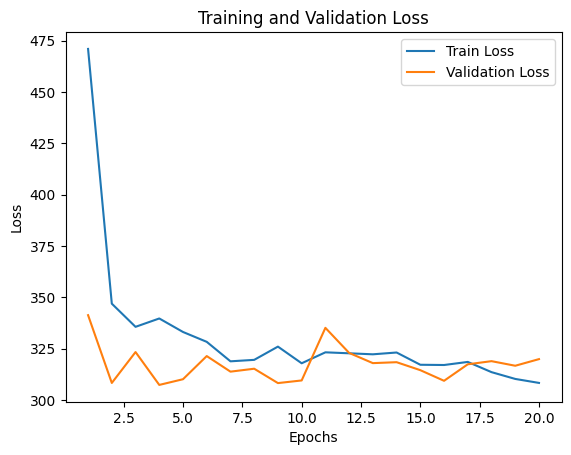

Test Accuracy: 32.08%


In [29]:
# Test CNN #

# Plot training and validation losses
plt.plot(range(1, CNN_epochs + 1), train_losses_spec, label='Train Loss')
plt.plot(range(1, CNN_epochs + 1), val_losses_spec, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate accuracy on the test set
CNN_model.eval()

# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient calculation for inference
        for i, (spectrograms, labels) in enumerate(test_loader_spec):  # Using the DataLoader
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            # Forward pass: get raw logits from the model
            y_pred_logits = CNN_model(spectrograms)  # Modify based on your model's forward function

            # Calculate accuracy with tolerance
            y_pred = y_pred_logits.squeeze()  # Ensure shape matches (N,)
            labels = labels.squeeze()

            correct_predictions += torch.sum(torch.abs(y_pred - labels) <= tolerance).item()
            total_predictions += labels.numel()

# Calculate accuracy
CNN_accuracy = (correct_predictions / total_predictions) * 100
print(f"Test Accuracy: {CNN_accuracy:.2f}%")

In [ ]:
# Save CNN #
torch.save(CNN_model.state_dict(), 'CNN_model_pre_train.pth')

In [32]:
# Train Naive Combine #
optimizer = optim.Adam(naivepredictor_model.parameters(), lr=Naive_LR)

# Training Loop
train_losses_comb, val_losses_comb = [], []

for epoch in range(Naive_epochs):
    naivepredictor_model.train()
    running_loss = 0.0

    for spectrograms, text_features, labels in train_loader_comb:
        spectrograms = spectrograms.to(device)  # Move to device
        text_features = text_features.to(device)  # Move to device
        labels = labels.to(device)  # Move to device

        optimizer.zero_grad()
        outputs = naivepredictor_model(spectrograms, text_features,naive = True)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels match output shape
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses_comb.append(running_loss / len(train_loader_comb))

    # Validation
    naivepredictor_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for spectrograms, text_features, labels in val_loader_comb:
            spectrograms = spectrograms.to(device)
            text_features = text_features.to(device)
            labels = labels.to(device)

            outputs = naivepredictor_model(spectrograms, text_features,naive = True)
            loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels match output shape

            val_loss += loss.item()

    val_losses_comb.append(val_loss / len(val_loader_comb))

    print(f"Epoch [{epoch+1}/{Naive_epochs}], Train Loss: {train_losses_comb[-1]:.4f}, Validation Loss: {val_losses_comb[-1]:.4f}")



Epoch [1/15], Train Loss: 405.1945, Validation Loss: 301.0646
Epoch [2/15], Train Loss: 347.5928, Validation Loss: 300.7654
Epoch [3/15], Train Loss: 320.9452, Validation Loss: 325.1340
Epoch [4/15], Train Loss: 333.5438, Validation Loss: 362.4976
Epoch [5/15], Train Loss: 301.6411, Validation Loss: 356.4274
Epoch [6/15], Train Loss: 295.1419, Validation Loss: 301.6949
Epoch [7/15], Train Loss: 296.2579, Validation Loss: 393.3256
Epoch [8/15], Train Loss: 298.7798, Validation Loss: 313.5731
Epoch [9/15], Train Loss: 312.7942, Validation Loss: 299.6097
Epoch [10/15], Train Loss: 295.0633, Validation Loss: 303.1001
Epoch [11/15], Train Loss: 297.3258, Validation Loss: 297.1300
Epoch [12/15], Train Loss: 294.4077, Validation Loss: 315.8131
Epoch [13/15], Train Loss: 296.2755, Validation Loss: 328.8014
Epoch [14/15], Train Loss: 284.2943, Validation Loss: 296.8270
Epoch [15/15], Train Loss: 286.3016, Validation Loss: 303.0214


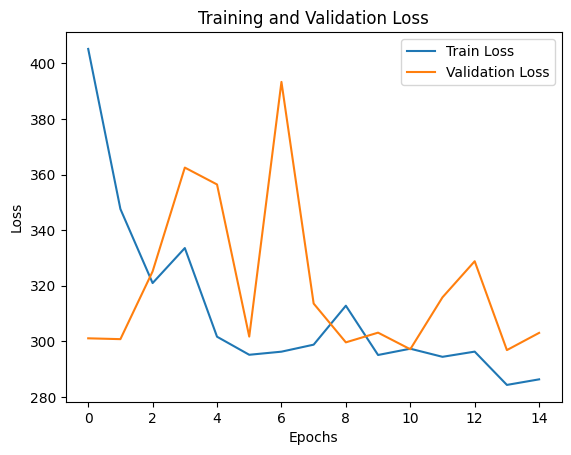

Test Accuracy: 60.42%


In [33]:
# Test Naive Combine #
# Plot Losses
plt.plot(train_losses_comb, label="Train Loss")
plt.plot(val_losses_comb, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

naivepredictor_model.eval()
# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient calculation for inference
    for spectrograms, text_features, labels in test_loader_comb:
        spectrograms = spectrograms.to(device)
        text_features = text_features.to(device)
        labels = labels.to(device)
        # Forward pass: get raw logits from the model
        y_pred_logits = naivepredictor_model(spectrograms, text_features)

        # Calculate accuracy with tolerance
        y_pred = y_pred_logits.squeeze()  # Ensure shape matches (N,)
        labels = labels.squeeze()

        correct_predictions += torch.sum(torch.abs(y_pred - labels) <= tolerance).item()
        total_predictions += labels.numel()

# Calculate accuracy
dumb_comb_accuracy = (correct_predictions / total_predictions) * 100
print(f"Test Accuracy: {dumb_comb_accuracy:.2f}%")

In [ ]:
# Save Naive Combine #
torch.save(naivepredictor_model.state_dict(), 'naivepredictor_model_reg_ver1.pth')

In [34]:
# Load Models for smart Combined Model
transformer_pre_trained_model = TransformerPredictor(train_text_features.shape[1]).to(device)
cnn_pre_trained_model = SpectrogramCNN().to(device)
# Load the state_dict
transformer_pre_trained_model.load_state_dict(torch.load('transformer_model_pre_train.pth'))
cnn_pre_trained_model.load_state_dict(torch.load('CNN_model_pre_train.pth'))
combined_smart_model = CombinedModel(cnn_pre_trained_model, transformer_pre_trained_model).to(device)

<ipython-input-34-3b9c247b65a4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_pre_trained_model.load_state_dict(torch.load('transformer_model_pre_train.pth'))

In [36]:
# Train Smart Combine #
optimizer = optim.Adam(combined_smart_model.parameters(), lr=Smart_LR)

# Training Loop
train_losses_comb_smart, val_losses_comb_smart = [], []

for epoch in range(Smart_epochs):
    combined_smart_model.train()
    running_loss = 0.0

    for spectrograms, text_features, labels in train_loader_comb2:
        spectrograms = spectrograms.to(device)  # Move to device
        text_features = text_features.to(device)  # Move to device
        labels = labels.to(device)  # Move to device

        optimizer.zero_grad()
        outputs = combined_smart_model(spectrograms, text_features, naive = False)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels match output shape
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses_comb_smart.append(running_loss / len(train_loader_comb2))

    # Validation
    combined_smart_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for spectrograms, text_features, labels in val_loader_comb2:
            spectrograms = spectrograms.to(device)
            text_features = text_features.to(device)
            labels = labels.to(device)

            outputs = combined_smart_model(spectrograms, text_features, naive = False)
            loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels match output shape

            val_loss += loss.item()

    val_losses_comb_smart.append(val_loss / len(val_loader_comb2))

    print(f"Epoch [{epoch+1}/{Smart_epochs}], Train Loss: {train_losses_comb_smart[-1]:.4f}, Validation Loss: {val_losses_comb_smart[-1]:.4f}")



Epoch [1/15], Train Loss: 372.3364, Validation Loss: 300.4967
Epoch [2/15], Train Loss: 298.6613, Validation Loss: 319.2157
Epoch [3/15], Train Loss: 299.0926, Validation Loss: 282.4171
Epoch [4/15], Train Loss: 296.8128, Validation Loss: 341.6791
Epoch [5/15], Train Loss: 293.7428, Validation Loss: 393.5480
Epoch [6/15], Train Loss: 289.6209, Validation Loss: 321.1984
Epoch [7/15], Train Loss: 293.9001, Validation Loss: 409.2566
Epoch [8/15], Train Loss: 287.8957, Validation Loss: 282.2793
Epoch [9/15], Train Loss: 286.9681, Validation Loss: 284.3841
Epoch [10/15], Train Loss: 292.0674, Validation Loss: 280.8143
Epoch [11/15], Train Loss: 284.7569, Validation Loss: 278.9047
Epoch [12/15], Train Loss: 278.5409, Validation Loss: 295.8573
Epoch [13/15], Train Loss: 279.5234, Validation Loss: 275.6821
Epoch [14/15], Train Loss: 282.6224, Validation Loss: 331.8716
Epoch [15/15], Train Loss: 281.2894, Validation Loss: 314.5449


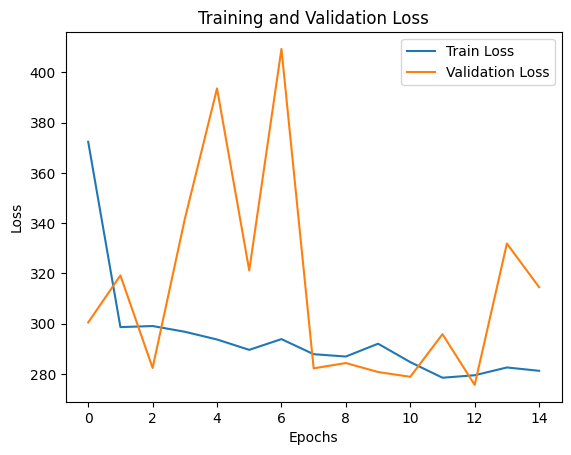

Test Accuracy: 62.08%


In [37]:
# Test Smart Combine #
# Plot Losses
plt.plot(train_losses_comb_smart, label="Train Loss")
plt.plot(val_losses_comb_smart, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

combined_smart_model.eval()
# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient calculation for inference
    for spectrograms, text_features, labels in test_loader_comb2:
        spectrograms = spectrograms.to(device)
        text_features = text_features.to(device)
        labels = labels.to(device)
        # Forward pass: get raw logits from the model
        y_pred_logits = combined_smart_model(spectrograms, text_features)

        # Calculate accuracy with tolerance
        y_pred = y_pred_logits.squeeze()  # Ensure shape matches (N,)
        labels = labels.squeeze()

        correct_predictions += torch.sum(torch.abs(y_pred - labels) <= tolerance).item()
        total_predictions += labels.numel()

# Calculate accuracy
Smart_comb_accuracy = (correct_predictions / total_predictions) * 100
print(f"Test Accuracy: {Smart_comb_accuracy:.2f}%")

In [ ]:
# Save Smart Combine #
torch.save(combined_smart_model.state_dict(), 'smart_model.pth')

## 🎯 Conclusions:
The CNN network as a stand-alone network is weak due to low number of samples.  
"Naive" way- combined network of transformers and CNN without any pre-training is not considering the epochs number needed for training each data separately and is not informative enough.  
"Smart" way- warming-up the network weights with pre-training and using it for predicting a combination 64 features output from each model (previous layer before output regression) gives more informative inferencing which improves accuracy.  
